In [1]:
import pandas as pd
import numpy as np
from glob import glob 

import cv2
import numpy as np

import pytesseract

"""
POC: Load Analyze-format MRI (.hdr/.img) and HDF5 data in Python
Requires: nibabel, h5py, numpy, matplotlib, pandas
"""

import os
import nibabel as nb
import matplotlib.pyplot as plt
from scipy import ndimage
import torch
from transformers import pipeline
from PIL import Image

/home/linux-pc/anaconda3/envs/torch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-05-10 22:10:08.671092: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-10 22:10:08.777601: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746929408.823988   77244 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746929408.835811   77244 cuda_blas.cc:

In [2]:
# Load data

data_dir = "./data/"
data_l = glob(data_dir + '*.csv')
print(data_l)

event_df = pd.read_csv(data_l[0])
eye_track_df = pd.read_csv(data_l[1])
motion_df = pd.read_csv(data_l[2])

# Monkey K2 (Kuma)
# Electrodes [52 -> 64] and [121 -> 128] (inclusive) are in the medial wall of the macaque brain.
ecog_df = pd.read_csv(data_l[3])


['./data/Event.csv', './data/EyeTrack.csv', './data/Motion.csv', './data/ECoG.csv']


In [30]:
event_df

,EventTime,EventData,EventIndex
0,1.994,1,1
1,5.656,2,5
2,477.235,3,477
3,480.288,4,480
4,784.158,1,784
5,787.462,2,787
6,1292.233,3,1292
7,1295.411,4,1295
8,1770.277,5,1770
9,1773.972,6,1773


In [4]:
motion_df.head()

,MotionTime,Kuma10mks_HeadSquare:LSHOx,Kuma10mks_HeadSquare:LSHOy,Kuma10mks_HeadSquare:LSHOz,Kuma10mks_HeadSquare:LELBx,Kuma10mks_HeadSquare:LELBy,Kuma10mks_HeadSquare:LELBz,Kuma10mks_HeadSquare:LWRIx,Kuma10mks_HeadSquare:LWRIy,Kuma10mks_HeadSquare:LWRIz,...,Kuma6mks:LWRIz,Kuma6mks:RSHOx,Kuma6mks:RSHOy,Kuma6mks:RSHOz,Kuma6mks:RELBx,Kuma6mks:RELBy,Kuma6mks:RELBz,Kuma6mks:RWRIx,Kuma6mks:RWRIy,Kuma6mks:RWRIz
0,0.000,-3.53105,-207.81749,174.46144,-17.79826,-156.28792,71.06341,-11.05089,-38.65305,46.61311,...,0.16501,473.02762,214.23267,190.96791,509.55225,244.84608,100.31995,427.32584,261.10004,58.72334
1,0.008,-3.51632,-207.84816,174.45848,-17.73650,-156.30830,71.05088,-11.06262,-38.65831,46.61407,...,-0.15992,473.03851,214.24710,190.97398,509.59723,244.81282,100.30188,427.34543,261.10968,58.70977
2,0.017,-3.50864,-207.85094,174.47888,-17.71475,-156.31816,71.02903,-11.05708,-38.65691,46.62395,...,-0.29376,473.07120,214.24551,190.92737,509.60425,244.81078,100.26740,427.36639,261.11008,58.70324
3,0.025,-3.48656,-207.86060,174.44635,-17.67327,-156.31963,71.02264,-10.88182,-38.65287,46.41671,...,-0.48042,473.08975,214.24385,190.87375,509.66629,244.76602,100.21867,427.42624,261.08759,58.68234
4,0.033,-3.44912,-207.87341,174.41740,-17.65565,-156.35741,71.01804,-10.87208,-38.70399,46.40196,...,-0.70778,473.09875,214.24925,190.89912,509.69113,244.72478,100.17921,427.45898,261.09012,58.63915


In [3]:
ecog_df.head()

,ECoG_time,ECoG_ch1,ECoG_ch2,ECoG_ch3,ECoG_ch4,ECoG_ch5,ECoG_ch6,ECoG_ch7,ECoG_ch8,ECoG_ch9,...,ECoG_ch119,ECoG_ch120,ECoG_ch121,ECoG_ch122,ECoG_ch123,ECoG_ch124,ECoG_ch125,ECoG_ch126,ECoG_ch127,ECoG_ch128
0,0.000,-105,-126,-366,-375,110,-51,-221,-103,-204,...,-23,178,104,-19,-185,-921,-52,-481,-29,5
1,0.001,-125,-152,-307,-364,95,-89,-174,-73,-228,...,-17,207,205,77,-103,-899,11,-465,-2,32
2,0.002,-102,-160,-314,-377,158,-70,-110,0,-199,...,-29,192,230,88,-91,-926,65,-486,8,2
3,0.003,-109,-190,-347,-416,186,-68,-78,23,-186,...,-49,192,277,125,-60,-969,70,-493,4,-31
4,0.004,-101,-175,-358,-418,203,-43,-46,78,-166,...,-52,169,346,161,-19,-997,124,-511,-5,-76


## Extracting centroids of ECoG array

In [5]:
image_path = "./imgs/K2.png"

In [6]:
raw_image = Image.open(image_path)

In [ ]:
# segment_anything_pipeline = pipeline("mask-generation", model="Zigeng/SlimSAM-uniform-77")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cuda:0


In [ ]:
# output = segment_anything_pipeline(raw_image, points_per_batch=32)

In [ ]:
# def extract_centroids(image_path):
#     # Read the image
#     image = cv2.imread(image_path)
#     gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale

#     # Use HoughCircles to detect circles in the image
#     circles = cv2.HoughCircles(
#         gray, 
#         cv2.HOUGH_GRADIENT, dp=1.2, minDist=30,
#         param1=50, param2=30, minRadius=10, maxRadius=100
#     )

#     # If circles are detected
#     if circles is not None:
#         circles = np.round(circles[0, :]).astype("int")  # Convert to integer

#         centroids = []
#         for circle in circles:
#             x, y, r = circle
#             centroids.append((x, y))
#             # Draw the circle and center on the image (optional for visualization)
#             cv2.circle(image, (x, y), r, (0, 255, 0), 4)  # Green circle
#             cv2.circle(image, (x, y), 2, (0, 0, 255), 3)  # Red center
#         # Show the image with detected circles (optional)
#         cv2.imshow("Detected Circles", image)
#         cv2.waitKey(0)
#         cv2.destroyAllWindows()

#         return centroids
#     else:
#         print("No circles were detected.")
#         return []

# # Example usage
# image_path = "./imgs/K2.png"
# centroids = extract_centroids(image_path)
# print("Centroid Coordinates:", centroids)


# Sulci Notes:
Sulci from right to left
1. Principal Sulcus (25 is at the principal sulcus)
2. Arcuate Sulcus
3. Central Sulcus
4. Intraparietal Sulcus
5. Lateral Sulcus or Sylvian Fissure (21 is at the conjunction of Superior Temporal Sulcus and Lateral Sulcus)
6. Superior Temporal Sulcus
7. Lunate Sulcus
8. Unknown. Possibly Calcarine Sulcus.

# MRI data

Analyze volume shape: (256, 256, 256)
Affine transform (vox→mm):
[[ -0.5    0.     0.    63.75]
 [  0.     0.5    0.   -63.75]
 [  0.     0.     0.5  -63.75]
 [  0.     0.     0.     1.  ]]


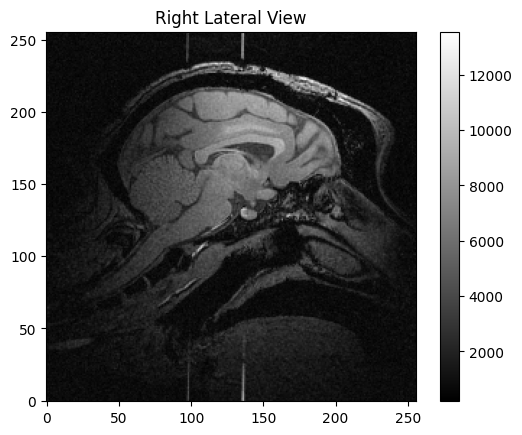

In [49]:

# ─────────────────────────────────────────────────────────────────────────────
# 1. Paths (edit these to your local files)
# ─────────────────────────────────────────────────────────────────────────────
analyze_hdr = "./data/mri/K2_t1.hdr"   # header for Analyze 7.5
# analyze_img = "./data/mri/K2_t1.img"   # binary data file



# ─────────────────────────────────────────────────────────────────────────────
# 2. Load Analyze-format volume with NiBabel
# ─────────────────────────────────────────────────────────────────────────────
# NiBabel will read the header and image automatically from the .hdr/.img pair.
mri_img = nb.load(analyze_hdr)             # you can equally pass analyze_img here
mri_data = mri_img.get_fdata(dtype=np.float32)
print(f"Analyze volume shape: {mri_data.shape}")
print(f"Affine transform (vox→mm):\n{mri_img.affine}")


sagittal_slice = mri_data[mri_data.shape[0]//2, : ,:]
left_lateral_view = np.flip(sagittal_slice, axis=0)

plt.imshow(left_lateral_view.T, cmap="gray", origin="lower")
plt.title("Right Lateral View")

plt.colorbar()
plt.show()


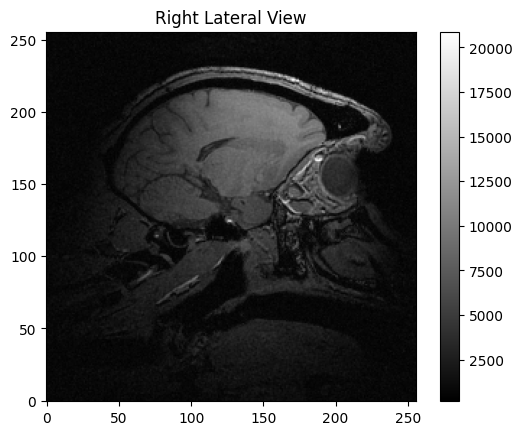

In [ ]:
# Display a middle axial slice
mid_z = mri_data.shape[2] // 2
plt.figure(figsize=(6,6))
plt.imshow(mri_data[:, :, mid_z].T, origin="lower", cmap="gray")
plt.title("Middle axial slice of Analyze volume")
plt.axis("off")
plt.show()


In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# 4. Summarize intensity distribution with pandas
# ─────────────────────────────────────────────────────────────────────────────
flat = mri_data.flatten()
stats = {
    "minimum": flat.min(),
    "maximum": flat.max(),
    "mean":    flat.mean(),
    "stddev":  flat.std()
}
df = pd.DataFrame(stats, index=["AnalyzeVolume"])
print("\nIntensity summary:")
print(df.to_string())

# ─────────────────────────────────────────────────────────────────────────────
# End of proof-of-concept
# ─────────────────────────────────────────────────────────────────────────────


# Identifying where the centroids of the ecog array are placed

In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# 1. Paths: replace these with your actual files
# ─────────────────────────────────────────────────────────────────────────────
# mri_nii   = "./path/to/preop_T1.nii.gz"       # your subject’s structural MRI
ct_nii    = "./imgs/K2.png" # "/path/to/postop_CT_with_ECoG.nii.gz"
atlas_nii = "./data/atlas/D99_v2.0_dist/D99_atlas_v2.0.nii.gz"  # e.g. CHARM or D99
labels_txt = "./data/atlas/D99_v2.0_dist/D99_v2.0_labels_semicolon.txt"
labels_csv= "./data/atlas/D99_v2.0_dist/D99_v2.0_labels_semicolon.csv"           # CSV: {index,label_name}


In [ ]:
# Converting text file to csv
# df = pd.read_csv(labels_txt, sep=";")
# df.to_csv(labels_csv)

In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# 2. Load images
# ─────────────────────────────────────────────────────────────────────────────
mri_img   = nb.load(analyze_hdr)
# ct_img    = nb.load(ct_nii)
atlas_img = nb.load(atlas_nii)

mri_data   = mri_img.get_fdata()
# ct_data    = ct_img.get_fdata()
atlas_data = atlas_img.get_fdata().astype(int)

In [ ]:

# ─────────────────────────────────────────────────────────────────────────────
# 3. Rigid-coregistration: estimate affine from CT → MRI
#    (In practice you’d do this once in ANTs or FSL and save the transform;
#     here we show a simple mutual-information based init from nibabel’s example)
# ─────────────────────────────────────────────────────────────────────────────
from nibabel.processing import resample_from_to
# Resample CT into MRI space (nearest for electrodes)
ct2mri = resample_from_to(ct_img, mri_img, order=0)  # order=0 preserves labels
ct2mri_data = ct2mri.get_fdata()

# ─────────────────────────────────────────────────────────────────────────────
# 4. Segment electrodes in CT (thresholding bright contacts),
#    find their centroids in MRI space
# ─────────────────────────────────────────────────────────────────────────────
# set a threshold high enough to isolate electrodes
thr = np.percentile(ct2mri_data[ct2mri_data>0], 99.5)
bw  = ct2mri_data > thr

# label connected components and compute centroids
labeled, n_labels = ndimage.label(bw)
objects = ndimage.find_objects(labeled)
centroids = []
for label_idx in range(1, n_labels+1):
    coords = np.argwhere(labeled == label_idx)
    if coords.size == 0:
        continue
    # mean in voxel space
    centroid_vox = coords.mean(axis=0)
    # convert to world
    centroid_mri = nb.affines.apply_affine(mri_img.affine, centroid_vox[::-1])
    centroids.append(centroid_mri)
centroids = np.array(centroids)

# ─────────────────────────────────────────────────────────────────────────────
# 5. Map each centroid into atlas indices and lookup label
# ─────────────────────────────────────────────────────────────────────────────
# Invert atlas affine
inv_atlas_affine = np.linalg.inv(atlas_img.affine)
labels = []
for xyz in centroids:
    vox = nb.affines.apply_affine(inv_atlas_affine, xyz)[::-1]
    vox = np.round(vox).astype(int)
    # guard against out-of-bounds:
    if np.any(vox < 0) or vox[0]>=atlas_data.shape[0] or vox[1]>=atlas_data.shape[1] or vox[2]>=atlas_data.shape[2]:
        labels.append("out_of_brain")
    else:
        lbl_idx = int(atlas_data[tuple(vox)])
        labels.append(lbl_idx)

# load your CSV of index→region
import csv
idx2name = {}
with open(labels_csv) as f:
    reader = csv.reader(f)
    for idx,name in reader:
        idx2name[int(idx)] = name

# translate indices to names
region_names = [idx2name.get(i, "unknown") for i in labels]

# ─────────────────────────────────────────────────────────────────────────────
# 6. Print out electrode → region table
# ─────────────────────────────────────────────────────────────────────────────
import pandas as pd
df = pd.DataFrame({
    "electrode_id": np.arange(len(centroids)) + 1,
    "x_mm": np.round(centroids[:,0],1),
    "y_mm": np.round(centroids[:,1],1),
    "z_mm": np.round(centroids[:,2],1),
    "atlas_index": labels,
    "region": region_names
})
print(df.to_string(index=False))

# ─────────────────────────────────────────────────────────────────────────────
# 7. (Optional) Quick coronal slice with electrodes overlaid
# ─────────────────────────────────────────────────────────────────────────────
slice_z = int(mri_data.shape[2]//2)
plt.imshow(mri_data[:,:,slice_z].T, cmap="gray", origin="lower")
pts = []
for (x,y,z), name in zip(centroids, region_names):
    if abs(z - nb.affines.apply_affine(mri_img.affine,[0,0,slice_z])[2])<2:
        pts.append((x, y))
xs, ys = zip(*pts)
plt.scatter(xs, ys, s=30, c="red")
plt.title("Coronal slice with detected ECoG centroids")
plt.show()
